In [1]:
import pandas as pd
import sqlite3
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

# Get Data

### Get Tables from DB into DataFrame

In [2]:
conn = sqlite3.connect("data/books.db") # download books.db and then add to folder called "data"
cursor = conn.cursor()

In [3]:
# Query to get table names
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
tables = cursor.fetchall()

# Print table names
for table in tables:
    print(table[0])

books


In [4]:
query = cursor.execute("SELECT * FROM books;")
cols = [column[0] for column in query.description]
genres_df = pd.DataFrame.from_records(data = query.fetchall(), columns = cols)

In [5]:
print(genres_df.head)

<bound method NDFrame.head of         average_rating                                      similar_books  \
0                 4.28  ["104760", "2115781", "571326", "294988", "211...   
1                 3.70  ["19549566", "23262675", "18629767", "18038539...   
2                 3.80  ["6288159", "5804806", "250541", "1641713", "7...   
3                 3.72  ["17312703", "13550737", "8598435", "15769230"...   
4                 3.04  ["18457720", "18658929", "23831821", "15742945...   
...                ...                                                ...   
248522            3.76  ["17154941", "12469130", "21564028", "16100093...   
248523            4.44  ["18284035", "16153261", "17317187", "17157392...   
248524            4.17  ["171202", "29609", "570911", "2380275", "7253...   
248525            4.45  ["723893", "90967", "7566", "7567", "270762", ...   
248526            3.89  ["17455988", "16111641", "17931500", "17191337...   

                                             

In [6]:
conn.close()

In [7]:
genres_df.dtypes

average_rating          float64
similar_books            object
description              object
authors                  object
num_pages               float64
book_id                  object
ratings_count             int64
title_without_series     object
genres                   object
dtype: object

# EDA

### For genres

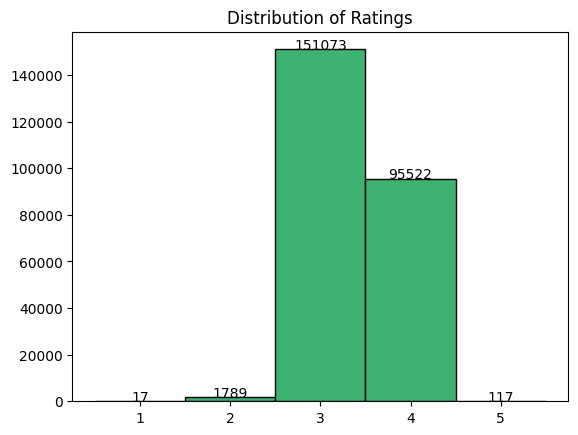

In [8]:
# histogram of ratings across all genres 
 
plt.title("Distribution of Ratings")
 
counts, bins, patches = plt.hist(genres_df['average_rating'], bins=range(1, 7), align='left', edgecolor='black', color='mediumseagreen')
for count, patch in zip(counts, patches):
    plt.text(patch.get_x() + patch.get_width() / 2, count + 0.5, int(count), ha='center')

In [9]:
# get mean, median, mode, and standard deviation of ratings and ratings count

print("more stats from describe() method:")
print(genres_df.describe())

more stats from describe() method:
       average_rating      num_pages  ratings_count
count   248527.000000  198326.000000   2.485270e+05
mean         3.890498     275.203997   1.180835e+03
std          0.322062     208.886465   6.862639e+03
min          0.000000       0.000000   0.000000e+00
25%          3.690000     175.000000   1.130000e+02
50%          3.900000     271.000000   2.460000e+02
75%          4.110000     352.000000   6.790000e+02
max          5.000000   37000.000000   1.082952e+06


In [10]:
highest_rated = genres_df.sort_values('average_rating', ascending=False).head(5)
lowest_rated = genres_df.sort_values('average_rating', ascending=True).head(5)

# Print the highest rated books based on average_rating 
print("Top 5 Highest Rated Books Based on average_rating:")
for i, (index, book) in enumerate(highest_rated.iterrows(), 1):
    print(f"{i}. {book['title']} - Rating: {book['average_rating']}, Number of Ratings: {book['ratings_count']}")

# Print the lowest rated books based on average_rating
print("\nBottom 5 Lowest Rated Books Based on average_rating:")
for i, (index, book) in enumerate(lowest_rated.iterrows(), 1):
    print(f"{i}. {book['title']} - Rating: {book['average_rating']}, Number of Ratings: {book['ratings_count']}")

Top 5 Highest Rated Books Based on average_rating:


KeyError: 'title'

In [ ]:
highest_rated = genres_df.sort_values('ratings_count', ascending=False).head(5)
lowest_rated = genres_df.sort_values('ratings_count', ascending=True).head(5)

# Print the highest rated books based on ratings_count
print("Top 5 Highest Rated Books Based on ratings_count:")
for i, (index, book) in enumerate(highest_rated.iterrows(), 1):
    print(f"{i}. {book['title']} - Number of Ratings: {book['ratings_count']}, Rating: {book['average_rating']}")

# Print the lowest rated books based on ratings_count 
print("\nBottom 5 Lowest Rated Books Based on ratings_count:")
for i, (index, book) in enumerate(lowest_rated.iterrows(), 1):
    print(f"{i}. {book['title']} - Number of Ratings: {book['ratings_count']}, Rating: {book['average_rating']}")

Top 5 Highest Rated Books Based on ratings_count:
1. Harry Potter and the Prisoner of Azkaban (Harry Potter, #3) - Number of Ratings: 1876252, Rating: 4.53
2. The Little Prince - Number of Ratings: 763309, Rating: 4.28
3. The Secret Garden - Number of Ratings: 652211, Rating: 4.12
4. Where the Wild Things Are - Number of Ratings: 635947, Rating: 4.22
5. Anne of Green Gables (Anne of Green Gables, #1) - Number of Ratings: 513174, Rating: 4.23

Bottom 5 Lowest Rated Books Based on ratings_count:
1. Drip, Drop - Number of Ratings: 0, Rating: 3.67
2. Alice's äfventyr i sagolandet - Number of Ratings: 0, Rating: 4.0
3. Pirate Diary: The Journal of Jake Carpenter - Number of Ratings: 0, Rating: 4.07
4. The Kids' Multicultural Cookbook: Food & Fun Around the World - Number of Ratings: 0, Rating: 4.23
5. Eggs over Evie - Number of Ratings: 0, Rating: 3.78



Pearson correlation coefficient: 0.0281
P-value: 5.7392e-19


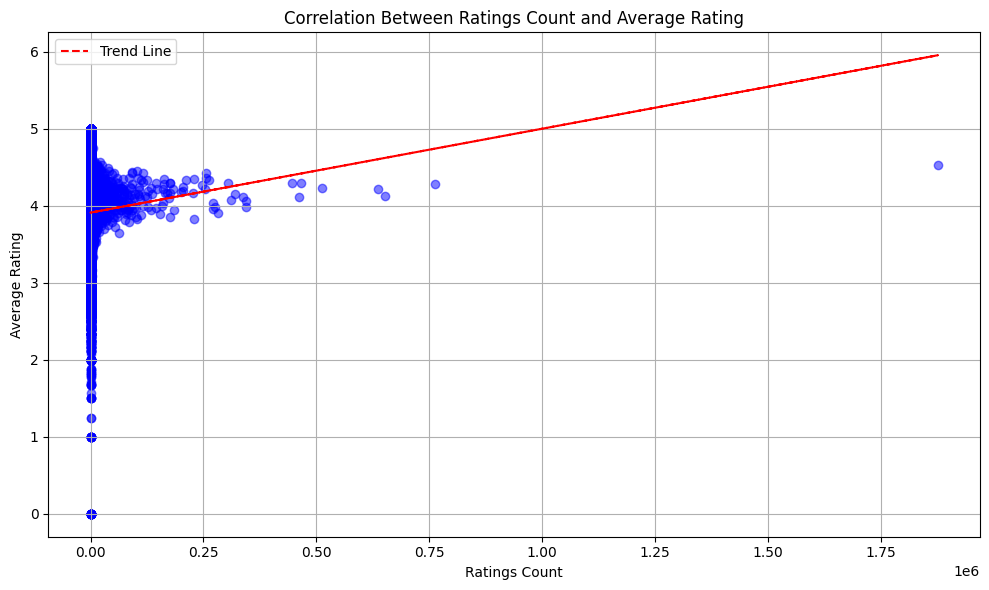

In [ ]:
filtered_books = genres_df[['ratings_count', 'average_rating']].dropna()

# Scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(filtered_books['ratings_count'], filtered_books['average_rating'], alpha=0.5, color='blue')
plt.xlabel('Ratings Count')
plt.ylabel('Average Rating')
plt.title('Correlation Between Ratings Count and Average Rating')
plt.grid(True)

# Add regression line
x = filtered_books['ratings_count']
y = filtered_books['average_rating']
m, b = np.polyfit(x, y, 1)
plt.plot(x, m * x + b, color='red', linestyle='--', label='Trend Line')

# Compute correlation coefficient
corr_coef, p_value = pearsonr(x, y)
print(f"\nPearson correlation coefficient: {corr_coef:.4f}")
print(f"P-value: {p_value:.4e}")

plt.legend()
plt.tight_layout()
plt.show()